In [ ]:
# !pip install open_clip_torch 

In [80]:
import open_clip
model, _, preprocess = open_clip.create_model_and_transforms('ViT-bigG-14', pretrained='laion2b_s39b_b160k')

print(p.numel() for p in model.parameters() if p.requires_grad)/1e9)


In [ ]:
# import torch
# model.to(torch.bfloat16)
# model.to('cuda')

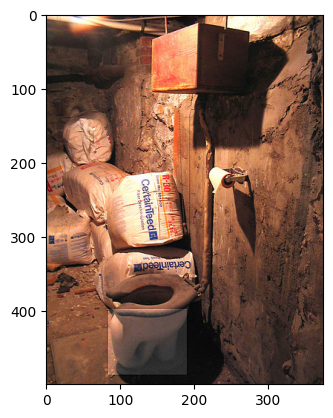

In [44]:
import matplotlib.pyplot as plt
plt.imshow(Image.open('/home/li/basu_workspace/cptData/train2014/COCO_train2014_000000482499.jpg'))

In [2]:
from PIL import Image
import torch

tokenizer = open_clip.get_tokenizer('ViT-B-32')

image = preprocess(Image.open('/home/li/basu_workspace/cptData/train2014/COCO_train2014_000000482499.jpg')).unsqueeze(0)
text = tokenizer(["a cave", "a cement bag", "a toilet"])

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

Label probs: tensor([[2.2635e-05, 4.9298e-01, 5.0700e-01]])


In [34]:
import numpy as np
import sys
import os
import json
from tqdm import trange

pth = os.path.abspath(os.path.dirname(os.path.dirname(os.path.dirname("__file__"))))

print(pth)
###################################################################################################                          

## LLaVA-Instruct-150K

from datasets import load_dataset
dataset = load_dataset("liuhaotian/LLaVA-Instruct-150K")

data_cleaned = []

for i in trange(len(dataset['train'])):
# for i in range(12):
    con = dataset['train'][i]['conversations']
    con = "###User: " + con[0]['value'] + "\n###Bot:" + con[1]['value']
    con = con.replace('<image>\n', '')
    data_cleaned.append(con)
    
    
sys.path.append(pth)
from llamaTokenizer import LLaMAtokenizer

tokenizer_path = os.path.join(os.path.dirname(pth), "cptData/lit-llama/tokenizer.model")

train_frac = 0.9
seq_len = 2048

tokenizer = LLaMAtokenizer(model_path=tokenizer_path)
enc = lambda s: tokenizer.encode(s, bos=False, eos=True)
dec = lambda s: tokenizer.decode(s)

encoded = [enc(data_cleaned[i]) for i in trange(len(data_cleaned))]
assert len (encoded) == len(data_cleaned)

encoded = [encoded[i] for i in range(len(encoded)) if len(encoded[i]) < seq_len]

# save encoded as pickle
import pickle

with open(os.path.join(pth, '../cptData/llava/encoded.pkl'), 'wb') as f:
    pickle.dump(encoded, f)

/home/li/basu_workspace/nanoGPT


Found cached dataset json (/home/li/.cache/huggingface/datasets/liuhaotian___json/liuhaotian--LLaVA-Instruct-150K-1764f60a2e27bb0f/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 394276/394276 [02:02<00:00, 3228.28it/s] 


In [57]:
imgs = []
for i in trange(len(dataset['train'])):
# for i in range(12):
    imgs.append(dataset['train'][i]['image'])

100%|██████████| 394276/394276 [00:29<00:00, 13225.30it/s]


In [87]:
from PIL import Image
import torch

dic = {}
pth = '/home/li/basu_workspace/cptData/llava/train2014'

dir_imgs = os.listdir(pth)

for i in trange(len(dir_imgs)):
    img = dir_imgs[i]
    image = preprocess(Image.open(os.path.join(pth, img))).unsqueeze(0)
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image)
        dic[img] = image_features
    if i == 5:
        break

  0%|          | 5/82783 [00:05<24:15:30,  1.06s/it]


In [52]:
## load encoded from pickle

encoded = pickle.load(open(os.path.join(pth, '../cptData/llava/encoded.pkl'), 'rb'))

In [35]:
totalTokens=0
for i in encoded:
    totalTokens+=len(i)
print("totalTokens: {:.2f}".format(totalTokens/1e6), "M")

totalTokens: 50.07 M


(array([1.52415e+05, 2.55800e+04, 1.30063e+05, 5.80320e+04, 1.36280e+04,
        7.91000e+03, 4.75800e+03, 1.55500e+03, 3.05000e+02, 3.00000e+01]),
 array([ 21. ,  75.2, 129.4, 183.6, 237.8, 292. , 346.2, 400.4, 454.6,
        508.8, 563. ]),
 <BarContainer object of 10 artists>)

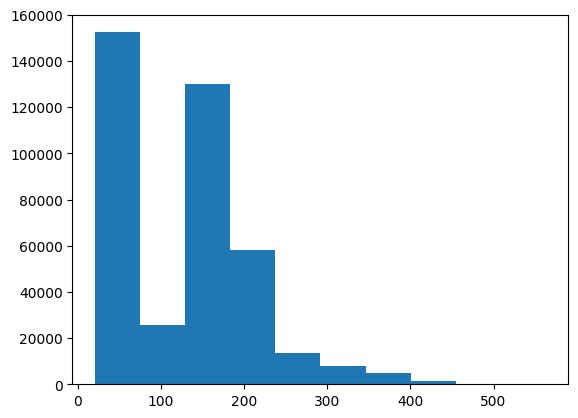

In [46]:
import matplotlib.pyplot as plt

lens = [len(i) for i in encoded]
lens = sorted(lens)
plt.hist(lens)

In [47]:
print(lens)

[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,

In [ ]:
totalTokens=0
for i in encoded:
    totalTokens+=len(i)
print("totalTokens: {:.2f}".format(totalTokens/1e6), "M")


num_train = totalTokens//seq_len + 1

train_ids = encoded[:int(train_frac*len(encoded))]
val_ids = encoded[int(train_frac*len(encoded)):]
print("train_ids.shape: ", train_ids.shape)
print("val_ids.shape: ", val_ids.shape)

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)

train_ids.tofile(os.path.join(pth, 'data/{dataset}/train.bin'.format(dataset=dataset)))
val_ids.tofile(os.path.join(pth, 'data/{dataset}/val.bin'.format(dataset=dataset)))

In [38]:
import os
import bisect
from tqdm import trange

imgs = os.listdir('/home/li/basu_workspace/cptData/train2014')
print(imgs[0])
de
imgs = [img[15:] for img in imgs]
imgs = sorted(imgs)


for i in trange(len(dataset['train'])):
    img = dataset['train'][i]['image']
    if bisect.bisect_left(imgs, img) == len(imgs) or imgs[bisect.bisect_left(imgs, img)] != img:
        print(img, i)
        raise ValueError('img not found')

COCO_train2014_000000482499.jpg


NameError: name 'de' is not defined

In [ ]:
##print name of all parameters

for name, param in model.named_parameters():
    if 'bias' not in name:
        print(name[:-7])


In [12]:
import numpy as np
import sys
import os
import json
from tqdm import trange

pth = os.path.abspath(os.path.dirname(os.path.dirname(os.path.dirname("__file__"))))

print(pth)
###################################################################################################                          

## alpaca cleaned
with open(os.path.join(pth, 'data/alpaca/alpaca_data_cleaned.json')) as f:
    data = json.load(f)

data_cleaned = []

for instruct in data:
    if instruct['input'] == "":
        data_cleaned.append("###User: " + instruct['instruction'] + "\n###Bot: " + instruct['output'])
    else:
        data_cleaned.append("###User: " + instruct['input'] + " " + instruct['instruction'] + "\n###Bot: " + instruct['output'])

print("Number of examples in alpaca: ", len(data_cleaned))

## dolly
with open(os.path.join(pth, 'data/dolly/databricks-dolly-15k.jsonl')) as f:
    data = f.readlines()
    
data = [json.loads(line) for line in data]
data_cleaned_dolly = []

for instruct in data:
    if instruct['context'] == "":
        data_cleaned_dolly.append("###User: " + instruct['instruction'] + "\n###Bot: " + instruct['response'])
    else:
        data_cleaned_dolly.append("###User: " + instruct['context'] + " " + instruct['instruction'] + "\n###Bot: " + instruct['response'])
print("Number of examples in dolly: ", len(data_cleaned_dolly))

data_cleaned += data_cleaned_dolly

# ## gpt4all
# from datasets import load_dataset

# data = load_dataset("nomic-ai/gpt4all-j-prompt-generations", revision='v1.3-groovy')
# data_cleaned_gpt4all  = ["###User: " + instruct['prompt'] + "\n###Bot: " + instruct['response'] for instruct in data['train']]

# print("Number of examples in gpt4all: ", len(data_cleaned_gpt4all))

# data_cleaned += data_cleaned_gpt4all

# print("Total number of examples: ", len(data_cleaned))
############################################################################################################

# ## save data_cleaned into a file
# with open(os.path.join(pth, 'data/instruct2/data_cleaned.json'), 'w') as f:
#     # convert into JSON:
#     dc_json = json.dumps(data_cleaned)
#     json.dump(dc_json, f)


sys.path.append(pth)
from llamaTokenizer import LLaMAtokenizer

tokenizer_path = os.path.join(os.path.dirname(pth), "cptData/lit-llama/tokenizer.model")

train_frac = 0.9
seq_len = 2048
dataset = 'instruct2'

tokenizer = LLaMAtokenizer(model_path=tokenizer_path)
enc = lambda s: tokenizer.encode(s, bos=False, eos=True)
dec = lambda s: tokenizer.decode(s)

encoded = [enc(data_cleaned[i]) for i in trange(len(data_cleaned))]
assert len (encoded) == len(data_cleaned)

encoded = [encoded[i] for i in range(len(encoded)) if len(encoded[i]) < seq_len]

## shuffle encoded
np.random.seed(42)
np.random.shuffle(encoded)

totalTokens=0
for i in encoded:
    totalTokens+=len(i)
print("totalTokens: {:.2f}".format(totalTokens/1e6), "M")


num_train = totalTokens//seq_len + 1

### converting 1d tokens to 2d batch of tokens 
comb = np.ones((num_train, seq_len), dtype=np.int32)*2 ## pad with eos_token_id

j, k = 0, 0

for i in trange(len(encoded)):
    sen = encoded[i]
    
    if k + len(sen) > seq_len:

        remlen = seq_len - k
        comb[j, -remlen:] = sen[:remlen]
        k = len(sen) - remlen
        l = [k]
        j+=1
        comb[j, :k] = sen[-k:]
    else:
        comb[j, k:len(sen)+k] = sen
        k+=len(sen)
    if k == seq_len:
        k = 0
        j+=1
        
sen_lens = []
for i in comb:
    idx_old = 0
    l = []
    for idx, j in enumerate(i):
        if j == 2:
            l.append(idx-idx_old + 1)
            idx_old = idx + 1
    l.append(len(i)-idx_old)
    sen_lens.append(l)


### check if all the tokens are accounted for (may remove this later)
all_lens = []
for i in sen_lens:
    all_lens+=i

j = 0
for i in trange(len(encoded)):
    if len(encoded[i]) == all_lens[j]:
        j+=1
    else:
        if len(encoded[i]) != all_lens[j] + all_lens[j+1]:
            assert False
        else:
            j+=2
            
all_lens = all_lens[:j]
            

ans = 0
for i in trange(len(encoded)):
    ans += len(encoded[i])
for j in all_lens:
    ans-=j
assert ans == 0


### remove empty sentences lengths from last batch
for i in trange(len(sen_lens[-1])):
    if sen_lens[-1][i] == 1:
        ans = i
        break
sen_lens[-1] = sen_lens[-1][:ans]


train_ids = comb[:int(train_frac*len(comb))]
val_ids = comb[int(train_frac*len(comb)):]

/home/li/basu_workspace/nanoGPT
Number of examples in alpaca:  51760
Number of examples in dolly:  15011


100%|██████████| 66771/66771 [00:26<00:00, 2520.71it/s]


totalTokens: 13.01 M


  0%|          | 2/1814 [00:00<00:00, 60349.70it/s]


In [18]:
sen_lens = [i + [0]*(seq_len - len(i)) for i in sen_lens]

In [19]:
train_lens = sen_lens[:int(train_frac*len(comb))]
val_lens = sen_lens[int(train_frac*len(comb)):]

print(len(train_lens), len(val_lens), train_ids.shape, val_ids.shape)

5717 636 (5717, 2048) (636, 2048)


In [ ]:


assert train_ids.shape[0] == len(train_lens) and val_ids.shape[0] == len(val_lens)

print("train_ids.shape: ", train_ids.shape)
print("val_ids.shape: ", val_ids.shape)

## flatten the seq lengths although not necessary as tofile flattens the array
train_lens = [item for sublist in train_lens for item in sublist]
val_lens = [item for sublist in val_lens for item in sublist]

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_lens = np.array(train_lens, dtype=np.uint16)
val_lens = np.array(val_lens, dtype=np.uint16)

train_ids.tofile(os.path.join(pth, 'data/{dataset}/train.bin'.format(dataset=dataset)))
val_ids.tofile(os.path.join(pth, 'data/{dataset}/val.bin'.format(dataset=dataset)))
train_lens.tofile(os.path.join(pth, 'data/{dataset}/inp_shape_train.bin'.format(dataset=dataset)))
val_lens.tofile(os.path.join(pth, 'data/{dataset}/inp_shape_val.bin'.format(dataset=dataset)))

In [ ]:
import numpy as np
import sys
import os
import json
from tqdm import trange

pth = os.path.abspath(os.path.dirname(os.path.dirname(os.path.dirname("__file__"))))

print(pth)
###################################################################################################                          

## alpaca cleaned
with open(os.path.join(pth, 'data/alpaca/alpaca_data_cleaned.json')) as f:
    data = json.load(f)

data_cleaned = []

for instruct in data:
    if instruct['input'] == "":
        data_cleaned.append("###User: " + instruct['instruction'] + "\n###Bot: " + instruct['output'])
    else:
        data_cleaned.append("###User: " + instruct['input'] + " " + instruct['instruction'] + "\n###Bot: " + instruct['output'])

print("Number of examples in alpaca: ", len(data_cleaned))

## dolly
with open(os.path.join(pth, 'data/dolly/databricks-dolly-15k.jsonl')) as f:
    data = f.readlines()
    
data = [json.loads(line) for line in data]
data_cleaned_dolly = []

for instruct in data:
    if instruct['context'] == "":
        data_cleaned.append("###User: " + instruct['instruction'] + "\n###Bot: " + instruct['response'])
    else:
        data_cleaned.append("###User: " + instruct['context'] + " " + instruct['instruction'] + "\n###Bot: " + instruct['response'])
print("Number of examples in dolly: ", len(data_cleaned_dolly))

data_cleaned += data_cleaned_dolly

# ## gpt4all
# from datasets import load_dataset

# data = load_dataset("nomic-ai/gpt4all-j-prompt-generations", revision='v1.3-groovy')
# data_cleaned_gpt4all  = ["###User: " + instruct['prompt'] + "\n\n###Bot: " + instruct['response'] for instruct in data['train']]

# print("Number of examples in gpt4all: ", len(data_cleaned_gpt4all))

# data_cleaned += data_cleaned_gpt4all

# print("Total number of examples: ", len(data_cleaned))
############################################################################################################

sys.path.append(pth)
from llamaTokenizer import LLaMAtokenizer

tokenizer_path = os.path.join(os.path.dirname(pth), "cptData/lit-llama/tokenizer.model")

train_frac = 0.9
seq_len = 2048
dataset = 'instruct2'

tokenizer = LLaMAtokenizer(model_path=tokenizer_path)
enc = lambda s: tokenizer.encode(s, bos=False, eos=True)
dec = lambda s: tokenizer.decode(s)

encoded = [enc(data_cleaned[i]) for i in trange(len(data_cleaned))]
assert len (encoded) == len(data_cleaned)

encoded = [encoded[i] for i in range(len(encoded)) if len(encoded[i]) < seq_len]

## shuffle encoded

np.random.seed(42)
np.random.shuffle(encoded)



In [2]:

np.random.seed(42)
np.random.shuffle(encoded)

In [9]:
np.random.shuffle(data_cleaned)


In [10]:
totalTokens = 4343214321
## print using format
print("totalTokens = {:.2f}".format(totalTokens/1e6))

totalTokens = 4343.21


In [ ]:
totalTokens=0
for i in encoded:
    totalTokens+=len(i)
print("totalTokens: ", totalTokens/1e6, "M")


num_train = totalTokens//seq_len + 1

### converting 1d tokens to 2d batch of tokens 
comb = np.ones((num_train, seq_len), dtype=np.int32)*2 ## pad with eos_token_id

j, k = 0, 0

for i in trange(len(encoded)):
    sen = encoded[i]
    
    if k + len(sen) > seq_len:

        remlen = seq_len - k
        comb[j, -remlen:] = sen[:remlen]
        k = len(sen) - remlen
        l = [k]
        j+=1
        comb[j, :k] = sen[-k:]
    else:
        comb[j, k:len(sen)+k] = sen
        k+=len(sen)
    if k == seq_len:
        k = 0
        j+=1
        
sen_lens = []
for i in comb:
    idx_old = 0
    l = []
    for idx, j in enumerate(i):
        if j == 2:
            l.append(idx-idx_old + 1)
            idx_old = idx + 1
    l.append(len(i)-idx_old)
    sen_lens.append(l)


### check if all the tokens are accounted for (may remove this later)
all_lens = []
for i in sen_lens:
    all_lens+=i

j = 0
for i in trange(len(encoded)):
    if len(encoded[i]) == all_lens[j]:
        j+=1
    else:
        if len(encoded[i]) != all_lens[j] + all_lens[j+1]:
            assert False
        else:
            j+=2
            
all_lens = all_lens[:j]
            

ans = 0
for i in trange(len(encoded)):
    ans += len(encoded[i])
for j in all_lens:
    ans-=j
assert ans == 0


### remove empty sentences lengths from last batch
for i in trange(len(sen_lens[-1])):
    if sen_lens[-1][i] == 1:
        ans = i
        break
sen_lens[-1] = sen_lens[-1][:ans]

train_lens = sen_lens[:int(train_frac*len(comb))]
val_lens = sen_lens[int(train_frac*len(comb)):]

train_ids = comb[:int(train_frac*len(comb))]
val_ids = comb[int(train_frac*len(comb)):]

assert train_ids.shape[0] == len(train_lens)
assert val_ids.shape[0] == len(train_lens)

print("train_ids.shape: ", train_ids.shape)
print("val_ids.shape: ", val_ids.shape)

## flatten the seq lengths although not necessary as tofile flattens the array
train_lens = [item for sublist in train_lens for item in sublist]
val_lens = [item for sublist in val_lens for item in sublist]

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_lens = np.array(train_lens, dtype=np.uint16)
val_lens = np.array(val_lens, dtype=np.uint16)

train_ids.tofile(os.path.join(pth, 'data/{dataset}/train.bin'.format(dataset=dataset)))
val_ids.tofile(os.path.join(pth, 'data/{dataset}/val.bin'.format(dataset=dataset)))
train_lens.tofile(os.path.join(pth, 'data/{dataset}/inp_shape_train.bin'.format(dataset=dataset)))
val_lens.tofile(os.path.join(pth, 'data/{dataset}/inp_shape_val.bin'.format(dataset=dataset)))

In [5]:
dec(comb[0].tolist())

'###User: \nGive three tips for staying healthy.\n###Bot: 1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night. ###User: \nWhat are the three primary colors?\n###Bot: The three primary colors are red, blue, and yellow. These colors are called primary because they cannot be created by mixing oth

In [6]:
dec(comb[1].tolist()) 

'ing in her new role, and had made new friends and connections in her new city. Looking back, Sophie was grateful for the opportunity to take a risk and make a change, and was confident that she had made the right decision for her career. ###User: He finnished his meal and left the resturant\nEvaluate this sentence for spelling and grammar mistakes\n###Bot: There are two spelling errors in the sentence. The corrected sentence should be: "He finished his meal and left the restaurant." ###User: \nHow did Julius Caesar die?\n###Bot: Julius Caesar, the Roman Military general, and statesman was assassinated on March 15, 44 BC. He was stabbed to death at a meeting of the Senate in the Theatre of Pompey by a group of senators who called themselves the Liberatores. Led by Gaius Cassius Longinus, and Marcus Junius Brutus, they believed that Caesar\'s dictatorship was subverting the Roman Republic and sought to restore the traditional republican government. The exact number of assailants is not 

In [ ]:
max_len = max([len(i) for i in sen_lens])

sen_lens = [i + [0]*(max_len - len(i)) for i in sen_lens]

inp_shape_train = sen_lens[:int(train_frac*len(comb))]
inp_shape_val = sen_lens[int(train_frac*len(comb)):]

train_ids = comb[:int(train_frac*len(comb))]
val_ids = comb[int(train_frac*len(comb)):]

assert train_ids.shape[0] == len(inp_shape_train)
assert val_ids.shape[0] == len(inp_shape_val)

print("train_ids.shape: ", train_ids.shape)
print("val_ids.shape: ", val_ids.shape)

inp_shape_train = [item for sublist in inp_shape_train for item in sublist]
inp_shape_val = [item for sublist in inp_shape_val for item in sublist]

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
inp_shape_train = np.array(inp_shape_train, dtype=np.uint16)
inp_shape_val = np.array(inp_shape_val, dtype=np.uint16)

train_ids.tofile(os.path.join(pth, 'data/{dataset}/train.bin'.format(dataset=dataset)))
val_ids.tofile(os.path.join(pth, 'data/{dataset}/val.bin'.format(dataset=dataset)))
inp_shape_train.tofile(os.path.join(pth, 'data/{dataset}/inp_shape_train.bin'.format(dataset=dataset)))
inp_shape_val.tofile(os.path.join(pth, 'data/{dataset}/inp_shape_val.bin'.format(dataset=dataset)))

In [34]:
# poor man's data loader

import os   
import numpy as np
dataset = 'dolly'
block_size = 2048


data_dir = os.path.join(os.path.dirname(os.path.realpath("__file__")), 'data', dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')

# print("Iterations per epoch:", train_data.shape[0] // tokens_per_iter)


# # if data_type == 'instruct':
# mask_train = np.memmap(os.path.join(data_dir, 'inp_shape_train.bin'), dtype=np.uint16, mode='r')
# mask_val = np.memmap(os.path.join(data_dir, 'inp_shape_val.bin'), dtype=np.uint16, mode='r')
# train_data = train_data.reshape(-1, block_size)
# val_data = val_data.reshape(-1, block_size)
# mask_train = mask_train.reshape(train_data.shape[0], -1)
# mask_val = mask_val.reshape(val_data.shape[0], -1)

In [18]:
decode(train_data[32542].tolist())

'###User: <p>Sorry for the easy question I am very new to IOS developing. What I would like to do is make the UILabel which is set to 0 go up by 1 every time a button is tapped on. Here is the default code given On the ViewController.swift and I have created an Outlet for the Label and Action for the Button. </p>\n\n<pre><code>import UIKit\n\nclass ViewController: UIViewController {\n@IBOutlet var score: UILabel!\n\n@IBAction func button(sender: UIButton) {\n\n\n}\n\noverride func viewDidLoad() {\n    super.viewDidLoad()\n\n}\n\noverride func didReceiveMemoryWarning() {\n    super.didReceiveMemoryWarning()\n\n}\n\n\n}\n</code></pre>\n###Bot: No need to apologize for asking a question! Here\'s how you can make the UILabel go up by 1 each time the button is tapped:\n\n1. Create a variable to keep track of the score:\n\n```\nvar currentScore = 0\n```\n\n2. In the `button` function, increment the `currentScore` variable and update the label text:\n\n```\n@IBAction func button(sender: UIBut

In [13]:
"""
Sample from a trained model
"""

from contextlib import nullcontext
import torch
from utils import load_model, get_tokenizer, print_gpu_utilization, time_gpu

# -----------------------------------------------------------------------------
init_from = ['resume', 'eval_llama', 'llama', 'gpt2-small', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'][1] # or 'resume' or 'gpt2-medium' or 'gpt2-large' or 'gpt2-xl'
out_dir = "/home/li/basu_workspace/cptData/out/lb2_llama_instruct_0607-1556"
start = "###User: Write a few words on Einstein.\n\n###Bot:"## Can also specify a file, use as: "FILE:prompt.txt"
num_samples =  3  # number of samples to draw
max_new_tokens = 200 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda:1' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster

# learning block
learning_block = True
influence = 0.5

## sampling
break_at_eos = False
eos_token_id = 2
# -----------------------------------------------------------------------------

model_type = 'llama' if 'llama' in init_from else 'gpt2'
sampling = "format" # "discrete" or "continuous" or "format"


# exec(open('configurator.py').read()) # overrides from command line or config file
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

torch.set_default_dtype(ptdtype)

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# # model
# model, model_args = load_model(model_type, out_dir, device, learning_block, influence, init_from)

# model.eval()

# with time_gpu('move model to device'):
#     model.to(device)

# print_gpu_utilization()

# if compile:
#     model = torch.compile(model) # requires PyTorch 2.0 (optional)


# tokenizer
encode, decode = get_tokenizer(model_type)
                        

    
    

In [14]:
import torch.nn.functional as F

@torch.no_grad()
def generate(idx, max_new_tokens, temperature=1.0, top_k=None, break_at_eos=False, eos_token_id=None):

    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = idx if idx.size(1) <= 2048 else idx[:, -2048:]
        # forward the model to get the logits for the index in the sequence
        logits = model(idx_cond)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1)
        print(idx_next)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
        
        if break_at_eos and idx_next.item() == eos_token_id:
            print("breaking at eos")
            break

    
    return idx

def sample(start):
    start_ids = encode(start)
    tkns = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    # run generation
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                with time_gpu('Time to generate'):
                    print("Sample", k+1, "------------------------------------")
                    y = generate(tkns, max_new_tokens, temperature=temperature, top_k=top_k,
                                       break_at_eos=break_at_eos, eos_token_id=eos_token_id)
                                       
                    print(decode(y[0].tolist()))
                    print('---------------')

In [ ]:
sample(start)

In [ ]:
                        
if sampling == "discrete":
    # encode the beginning of the prompt
    if start.startswith('FILE:'):
        with open(start[5:], 'r', encoding='utf-8') as f:
            start = f.read()
            sample(start)


elif sampling == "continuous":
    while True:
        ## take input
        print("Enter a sentence to continue:")
        start = str(input())
        sample(start)
        
elif sampling == "format":
    while True:
        ## take input
        print("Enter a sentence to continue:")
        start = str(input())
        start = "###User: " + start + "\n\n###Bot: "
        sample(start)

In [1]:
import os
import time
import math
import pickle
from contextlib import nullcontext
import numpy as np
from tqdm import trange
import torch
import torch.nn.functional as F
from torcheval.metrics.text import Perplexity
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from utils import load_model, Sampler, get_batch, configure_optimizers, time_gpu, get_pred_idxs

# -----------------------------------------------------------------------------
# default config values designed to train a gpt2 (124M) on OpenWebText
# I/O
out_dir = 'out'
eval_interval = 2000
log_interval = 1
eval_iters = 200
eval_only = False # if True, script exits right after the first eval
sample_start = "The king exclaimed thou"
max_new_tokens=100
always_save_checkpoint = True # if True, always save a checkpoint after each eval
init_from = 'scratch' # or 'resume' or 'gpt2-medium' or 'gpt2-large' or 'gpt2-xl' or 'eval_llama' or 'llama'
# wandb logging
wandb_log = False # disabled by default
wandb_project = "transformers"
wandb_run_name = 'gpt2' # 'run' + str(time.time())
# data
dataset = 'openwebtext'
gradient_accumulation_steps = 1 # used to simulate larger batch sizes
batch_size = 32 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 2048
# model
n_layers = 12
n_heads = 12
n_embd = 768
dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
bias = False # do we use bias inside LayerNorm and Linear layers?
# adamw optimizer
learning_rate = 6e-4 # max learning rate
max_iters = 600000 # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 2000 # how many steps to warm up for
lr_decay_iters = 600000 # should be ~= max_iters per Chinchilla
min_lr = 6e-5 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
torch.set_default_dtype(ptdtype)

# learning block
learning_block = False
influence = 0.5

## instruct
data_type = None
break_at_eos=False
eos_token_id=1
train_on_user_only = False

## testing
test_only = False

# -----------------------------------------------------------------------------

config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
eval_interval = 5
eval_iters = 40
wandb_log = True # feel free to turn on
wandb_project = 'learning-block'

sample_start = "###User: Write a few words on Einstein.\n###Bot:"
max_new_tokens = 100

wandb_run_name = 'lb2_llama_instruct' + '_' + time.strftime("%m%d-%H%M") ## train_type,  model , dataset
dataset = 'instruct2'
init_from = 'llama'

data_type = 'instruct'
out_dir = '../cptData/out/' + wandb_run_name 

# only save checkpoints if the validation loss improves
always_save_checkpoint = False

# the number of examples per iter:
# 1 batch_size * 32 grad_accum * 1024 tokens = 32,768 tokens/iter
# shakespeare has 301,966 tokens, so 1 epoch ~= 9.2 iters
batch_size = 2
gradient_accumulation_steps = 32
max_iters = 7500//batch_size

learning_block = True
device = 'cuda:1'

learning_rate = 3e-4
lr_decay_iters = 300
decay_lr = True
warmup_iters = 20

compile = False

break_at_eos = False
eos_token_id = 2

train_on_user_only = False

# exec(open('configurator.py').read()) # overrides from command line or config file
config = {k: globals()[k] for k in config_keys} # will be useful for logging
# -----------------------------------------------------------------------------

model_type = 'llama' if 'llama' in init_from else 'gpt2'

## if torch version < 2 set compile to False
if torch.__version__[0] == '1' and compile:
    print("PyTorch version < 2.0, disabling compilation")
    compile = False

print("Using Learning Block", learning_block)

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    assert gradient_accumulation_steps % torch.cuda.device_count() == 0
    gradient_accumulation_steps //= torch.cuda.device_count()
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * batch_size * block_size

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# poor man's data loader
data_dir = os.path.join(os.path.dirname(os.path.realpath("__file__")), 'data', dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')

print("Iterations per epoch:", train_data.shape[0] // tokens_per_iter)


if data_type == 'instruct':
    mask_train = np.memmap(os.path.join(data_dir, 'inp_shape_train.bin'), dtype=np.uint16, mode='r')
    mask_val = np.memmap(os.path.join(data_dir, 'inp_shape_val.bin'), dtype=np.uint16, mode='r')
    train_data = train_data.reshape(-1, block_size)
    val_data = val_data.reshape(-1, block_size)
    mask_train = mask_train.reshape(train_data.shape[0], -1)
    mask_val = mask_val.reshape(val_data.shape[0], -1)

# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9

# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

# model init
model_args = dict(n_layers=n_layers, n_heads=n_heads, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout, learning_block=learning_block) # start with model_args from command line


# model, model_args = load_model(model_type, out_dir, device, learning_block, influence, init_from)

# with time_gpu(device, 'model to GPU'):
#     model.to(device)

# ## set requires grad to false for all layers except learning block

# if learning_block:
#     print("setting requires_grad=False for all layers except learning block")
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             if "learning_block" not in name:
#                 param.requires_grad = False

## total number of parameters that requires grad
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("total params with requires grad", total_params/1e6, "M")

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = configure_optimizers(model, weight_decay, learning_rate, (beta1, beta2), device_type)
# if init_from == 'resume':
#     optimizer.load_state_dict(checkpoint['optimizer'])
checkpoint = None # free up memory

# compile the model
if compile:
    with time_gpu(device, 'compiling model'):
        print("compiling the model... (takes a ~minute)")
        model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

sampler = Sampler(model_name = model_type, start = sample_start, device = device)

perplexity = Perplexity()
perplexity.to(device)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()

    print("Sampling from trained model")
    sampler.generate(model, max_new_tokens=max_new_tokens, break_at_eos = break_at_eos,eos_token_id = eos_token_id) 

    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, mask, pred_idxs = get_batch(split, block_size, batch_size, device_type, device, train_data, val_data, 
                                   data_type = data_type, mask_train = mask_train, mask_val = mask_val, train_on_user_only = train_on_user_only)
                
            with ctx:
                logits = model(X, mask = mask)
                                
            if train_on_user_only:
                logits = logits.gather(1, torch.tensor(pred_idxs, device=device).unsqueeze(2).repeat(1,1,logits.size(-1))).squeeze(2)
                Y = Y.gather(1, torch.tensor(pred_idxs, device=device)).squeeze(1)

            perplexity.update(logits, Y)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=-1)
            losses[k] = loss.item()
        out[split] = losses.mean()
        print(f"perplexity on {split} split: {perplexity.compute():.3f}")
        perplexity.reset()
        
    model.train()
    return out


Using Learning Block True
Iterations per epoch: 3659


NameError: name 'model' is not defined

In [2]:
wandb_log = False

In [3]:
if test_only:
    print("Testing the model only")
    with time_gpu(device,'Ealuate'):
        losses = estimate_loss()
        
    print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    exit()

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb_api_key = "84742742b66deb0de22b5dfec52ec1f23a539d9b"
    wandb.init(project=wandb_project, name=wandb_run_name, entity='basujindal123',config=config)

# training loop
X, Y, mask, pred_idxs = get_batch('train', block_size, batch_size, device_type, device, train_data, val_data,
                       data_type = data_type, mask_train = mask_train, mask_val = mask_val, train_on_user_only = train_on_user_only)


In [2]:
X, Y, mask, pred_idxs = get_batch('train', block_size, 1, device_type, device, train_data, val_data,
                       data_type = data_type, mask_train = mask_train, mask_val = mask_val, train_on_user_only = train_on_user_only)

In [3]:
mask.shape, X.shape, Y.shape

(torch.Size([1, 2047, 2047]), torch.Size([1, 2047]), torch.Size([1, 2047]))

In [5]:


t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
iter_num_resume = iter_num
        
        
print("Training")
for iter_num in range(iter_num_resume, max_iters+1):

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


    with time_gpu(device, 'Training Step'):
        
        for micro_step in range(gradient_accumulation_steps):
            if ddp:
                model.require_backward_grad_sync = (micro_step == gradient_accumulation_steps - 1)
            with ctx:
                print(X.shape, mask.shape)
                logits = model(X, mask = mask)
                
            if train_on_user_only:
                logits = logits.gather(1, torch.tensor(pred_idxs, device=device).unsqueeze(2).repeat(1,1,logits.size(-1))).squeeze(2)
                Y = Y.gather(1, torch.tensor(pred_idxs, device=device)).squeeze(1)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=-1)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
                
            # immediately async prefetch next batch while model is doing the forward pass on the GPU
            X, Y, mask, pred_idxs = get_batch('train', block_size, batch_size, device_type, device, train_data, val_data,
                                   data_type = data_type, mask_train = mask_train, mask_val = mask_val, train_on_user_only = train_on_user_only)
            
            scaler.scale(loss).backward()
        # clip the gradient
        if grad_clip != 0.0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1
    local_iter_num += 1

if ddp:
    destroy_process_group()

Training
torch.Size([2, 2047]) torch.Size([2, 2047, 2047])
torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 2047])
torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 2047])
torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 2047])
torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 2047])
torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 2047])
torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 2047])
torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 2047])
torch.Size([2, 32, 2047, 128]) torch.Size([2, 32, 2047, 128]) torc

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 1; 39.41 GiB total capacity; 36.96 GiB already allocated; 284.50 MiB free; 37.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [49]:
comb = np.ones((len(encoded), seq_len), dtype=np.int32)*2
j = 0
k = 0
sen_lens = []
l = []
for i in encoded:
    if k + len(i) > seq_len:
        sen_lens.append(l)
        l = [len(i)]
        j+=1
        k=len(i)
    else:
        k+=len(i)
        l.append(len(i))
    comb[j, k-len(i):k] = i

for i in range(len(comb)):
    if np.all(comb[i] == 2):
        num_sen = i-1
        break

comb = comb[:num_sen]

max_len = max([len(i) for i in sen_lens])
## pad sen_lens with zeros
sen_lens = [i + [0]*(max_len - len(i)) for i in sen_lens]
sen_lens = [item for sublist in sen_lens for item in sublist]

train_frac = 0.9
train_ids = comb[:int(train_frac*len(comb))]
val_ids = comb[int(train_frac*len(comb)):]


# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
sen_lens = np.array(sen_lens, dtype=np.uint16)
train_ids.tofile('/home/li/basu_workspace/nanoGPT/data/dolly/train.bin')
val_ids.tofile( '/home/li/basu_workspace/nanoGPT/data/dolly/val.bin')
sen_lens.tofile('/home/li/basu_workspace/nanoGPT/data/dolly/sen_lens.bin')

In [4]:
import json

with open('/home/li/basu_workspace/nanoGPT/data/databricks-dolly-15k.jsonl') as f:
    data = f.readlines()
    
data = [json.loads(line) for line in data]
data_cleaned  = ["User: " + instruct['instruction'] + "\nBot: " + instruct['response'] for instruct in data]

In [5]:
encoded = []
for sentence in data_cleaned:
    encoded.append(enc(sentence))
assert len (encoded) == len(data_cleaned)

In [6]:
lens = [len(encoded[i]) for i in range(len(encoded))]
sorted_lens = sorted(lens)
pl = plt.hist(sorted_lens[:-200], bins=1000)

In [ ]:
import torch
import safetensors
from safetensors.torch import save_model

save_model(model, 'my_model.safetensors')

# tensors = {}
# with safe_open("model.safetensors", framework="pt", device="cpu") as f:
#    for key in f.keys():
#        tensors[key] = f.get_tensor(key)

In [ ]:
import safetensors
safetensors.torch.load_model(model, 'my_model.safetensors')